# Executive Exploratory Data Analysis

#### Expected Audience: 
This is a high level summary of the work and is intended for an audience with some understanding of data science/statistics, as such I have not introduced the statistical methods used
#### Personal circumstances:
Matt suggested a note on this is useful - I have a full time job and a young family which take most of my time! I am interested in Bitcoin and would like to make a competitive contribution to the project - very interested in your feedback especially on any areas which I have overlooked or techniques which might prove more useful on the polymarket data.

## Executive Summary

> MVRV is the only on-chain metric with robust, regime-stable, multi-method confirmed predictive power over Bitcoin 
> price. Unfortunately, Polymarket data has not been shown to add anything beyond the on-chain data.

### Five Key Findings

1. **MVRV dominates all other signals** — confirmed by Granger causality (p = 2.16e-25), mutual information, and wavelet coherence across all timescales from 1 week to 4 years. 
2. **Return momentum is present** — ΔROI30d and ΔROI1yr both survive multiple comparison correction and show stable rolling correlations across bull and bear markets.

3. **Non-linear signals exist but are unexploited** — ΔCapMrktCurUSD has the highest mutual information of all features (0.029) but fails 
   Granger's linear test. A non-linear model may be able to extract additional value.

4. **Polymarket data is coincident rather than predictive** — 12 signals tested across all 6 data files. None survive multiple comparison correction. Prediction markets efficiently incorporate public information and add no incremental predictive power over MVRV.

5. **Fed uncertainty predicts BTC volatility, not direction** — Polymarket Fed decision odds predict 30-day forward BTC volatility (p = 0.004) with a negative relationship: high uncertainty precedes lower volatility. Could be useful for DCA sizing rather than timing.

---

*Full analysis: `EDA.ipynb` | cell 11 for stationarity, cell 16 for granger tests, cell 26 for polymarket data audit*

In [5]:
# NB computation already done in EDA.ipynb - this notebook loads pre-saved outputs only
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings 
import sys
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 200

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if 'eda' in str(NOTEBOOK_DIR) else NOTEBOOK_DIR
DATA_DIR  = PROJECT_ROOT / "data"
PLOTS_DIR = NOTEBOOK_DIR / "plots"


sys.path.insert(0, str(PROJECT_ROOT))


from template.prelude_template import load_data


btc_pd = load_data()
btc_pd.index = pd.to_datetime(btc_pd.index)

print("Setup complete")
print(f"   Project root: {PROJECT_ROOT}")
print(f"   BTC data: {btc_pd.index.min().date()} "
      f"to {btc_pd.index.max().date()}")
print(f"   Plots directory exists: {PLOTS_DIR.exists()}")

2026-02-25 09:59:49 INFO     Loading CoinMetrics BTC data from local file: /home/dg/Documents/bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv
2026-02-25 09:59:49 WARNING  Missing BTC-USD prices for 1 dates from 2018-01-01 to 2026-01-14. First missing date: 2026-01-14
2026-02-25 09:59:49 INFO     Loaded CoinMetrics data: 6221 rows, 2009-01-03 to 2026-01-14


Setup complete
   Project root: /home/dg/Documents/bitcoin-analytics-capstone-template
   BTC data: 2009-01-03 to 2026-01-14
   Plots directory exists: True



## 1. Data Sources & Coverage

Two primary datasets were used in this analysis:

| Dataset | Source | Coverage | Key Fields |
|---|---|---|---|
| **CoinMetrics BTC** | Coin Metrics | 2010–2026 (5,659 days) | Price, MVRV, HashRate, Flows, Supply |
| **Polymarket** | Polymarket API | 2020–2026 (78,321 markets) | Odds, Trades, Volume |

**After cleaning:** 23 on-chain features retained. 
562 early rows dropped (pre-PriceUSD availability). 
4 columns dropped (>50% missing or zero variance).

*See `EDA.ipynb` cells 3-7 for full data integrity checks and cleaning pipeline.*

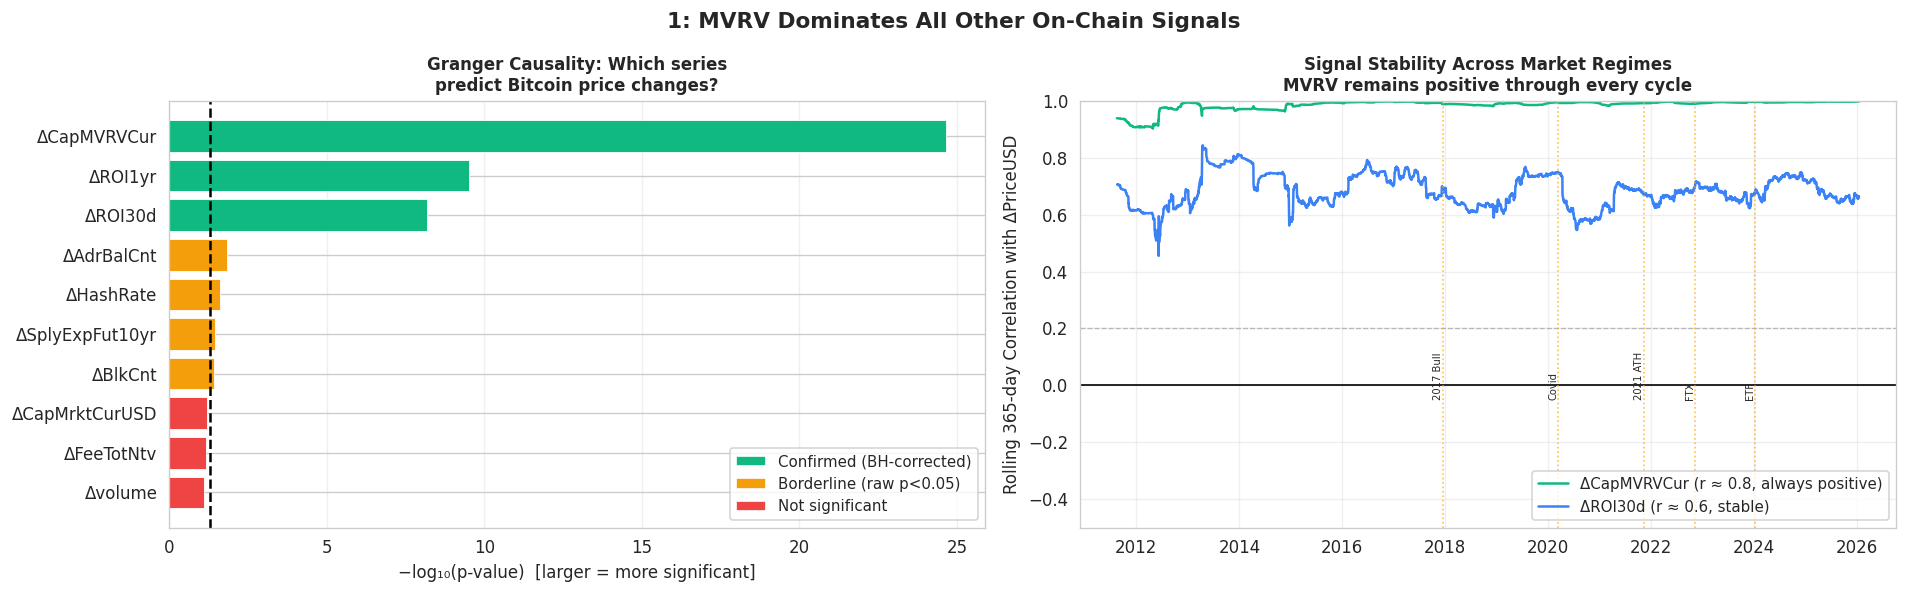

Key insight: MVRV has been positively correlated with BTC returns in every year since 2013


In [6]:
# 1: MVRV Signal Dominance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('1: MVRV Dominates All Other On-Chain Signals',
             fontsize=13, fontweight='bold')

# Left: Granger p-values (recreate from stored results)
granger_data = {
    'ΔCapMVRVCur':   2.161e-25,
    'ΔROI1yr':       2.997e-10,
    'ΔROI30d':       6.420e-09,
    'ΔAdrBalCnt':    1.451e-02,
    'ΔHashRate':     2.386e-02,
    'ΔSplyExpFut10yr': 3.495e-02,
    'ΔBlkCnt':       3.905e-02,
    'ΔCapMrktCurUSD':6.466e-02,
    'ΔFeeTotNtv':    6.869e-02,
    'Δvolume':       8.113e-02,
}
confirmed = ['ΔCapMVRVCur', 'ΔROI1yr', 'ΔROI30d']
borderline = ['ΔAdrBalCnt', 'ΔHashRate', 'ΔSplyExpFut10yr', 'ΔBlkCnt']

ax = axes[0]
colors = ['#10b981' if k in confirmed
          else '#f59e0b' if k in borderline
          else '#ef4444'
          for k in granger_data.keys()]

bars = ax.barh(
    list(granger_data.keys()),
    [-np.log10(v) for v in granger_data.values()],
    color=colors, edgecolor='white', linewidth=0.5
)
ax.axvline(-np.log10(0.05), color='black',
           linestyle='--', linewidth=1.5,
           label='p=0.05 threshold')
ax.set_xlabel('−log₁₀(p-value)  [larger = more significant]', fontsize=10)
ax.set_title('Granger Causality: Which series\npredict Bitcoin price changes?',
             fontsize=10, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='Confirmed (BH-corrected)'),
    Patch(facecolor='#f59e0b', label='Borderline (raw p<0.05)'),
    Patch(facecolor='#ef4444', label='Not significant'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

# Right: rolling correlation stability
ax = axes[1]

# recompute for this chart
btc_log_ret = np.log(btc_pd['PriceUSD']).diff()

# need diff_df — recompute MVRV diff
mvrv_log = np.log1p(btc_pd['CapMVRVCur'].dropna())
mvrv_diff = mvrv_log.diff()
roi30_diff = btc_pd['ROI30d'].dropna().diff()

# align
common = btc_log_ret.index.intersection(
    mvrv_diff.index).intersection(roi30_diff.index)
btc_r  = btc_log_ret.loc[common]
mvrv_d = mvrv_diff.loc[common]
roi30_d = roi30_diff.loc[common]

roll_mvrv  = mvrv_d.rolling(365).corr(btc_r)
roll_roi30 = roi30_d.rolling(365).corr(btc_r)

ax.plot(common, roll_mvrv,
        linewidth=1.5, color='#10b981',
        label='ΔCapMVRVCur (r ≈ 0.8, always positive)')
ax.plot(common, roll_roi30,
        linewidth=1.5, color='#3b82f6',
        label='ΔROI30d (r ≈ 0.6, stable)')
ax.axhline(0, color='black', linewidth=1)
ax.axhline(0.2, color='gray', linestyle='--',
           linewidth=0.8, alpha=0.5)

# key events
events = {
    '2017 Bull': '2017-12-17',
    'Covid':     '2020-03-12',
    '2021 ATH':  '2021-11-10',
    'FTX':       '2022-11-08',
    'ETF':       '2024-01-10',
}
for label, date in events.items():
    ax.axvline(pd.Timestamp(date), color='orange',
               linestyle=':', linewidth=1, alpha=0.7)
    ax.text(pd.Timestamp(date),
            ax.get_ylim()[0] if ax.get_ylim()[0] > -1 else -0.9,
            label, rotation=90, fontsize=6,
            va='bottom', ha='right')

ax.set_ylabel('Rolling 365-day Correlation with ΔPriceUSD', fontsize=10)
ax.set_title('Signal Stability Across Market Regimes\n'
             'MVRV remains positive through every cycle',
             fontsize=10, fontweight='bold')
ax.legend(fontsize=9, loc='lower right')
ax.set_ylim(-0.5, 1.0)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'exec_01_mvrv_dominance.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Key insight: MVRV has been positively correlated with BTC returns in every year since 2013")

### Why MVRV Works

**MVRV = Market Value ÷ Realised Value** — the ratio of what Bitcoin 
is worth *now* to what holders *paid for it*.

- When MVRV rises sharply → market is paying far above holder cost basis 
  → historically precedes corrections → **reduce accumulation**
- When MVRV falls → holders are underwater → capitulation signal 
  → **accelerate accumulation**

The Granger test (p = 2.16e-25) confirms that changes in MVRV 
**statistically precede** Bitcoin price changes by up to 7 days.
The wavelet coherence confirms this relationship holds at **every 
timescale from 1 week to 4 years** — it is not a cycle-specific artefact.

This directly validates the Example 1 model's 64% MVRV weight.

---
*Deep dive: `EDA.ipynb` — Granger Causality (cell 16), Rolling Correlation (cell 13), Wavelet Coherence (cell 49)*

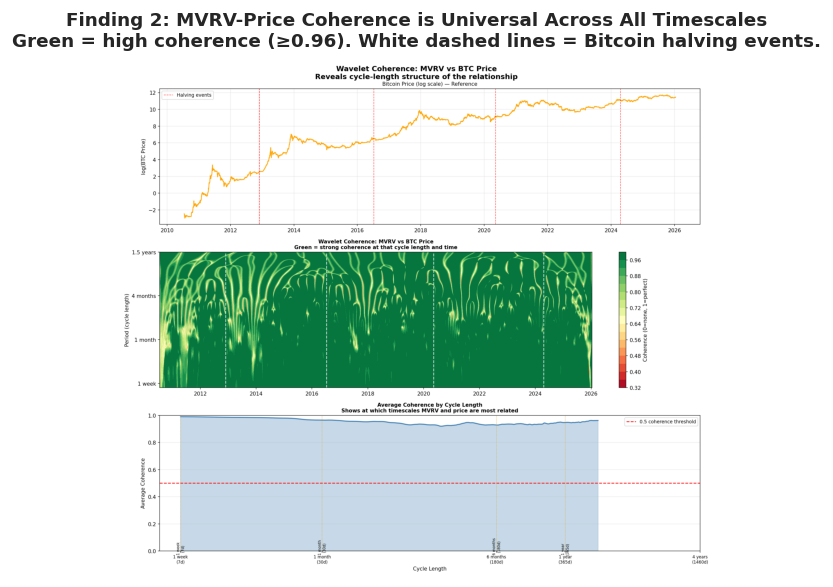


Reading the chart:
• The heatmap is almost entirely deep green — coherence ≥ 0.96 everywhere
• This means MVRV and BTC price move together at ALL cycle lengths: weekly (bottom), monthly (middle), and annual (top)  
• The relationship does not strengthen or weaken around halving events
• Conclusion: MVRV reveals a fundamental property of Bitcoin valuation, not something which is cycle-specific



In [7]:
# 2: Wavelet Coherence
# display the saved wavelet chart (computation intensive — done in EDA.ipynb)
fig, ax = plt.subplots(figsize=(16, 5))
ax.axis('off')

wavelet_img = mpimg.imread(str(PLOTS_DIR / 'eda_16_wavelet_coherence.png'))
ax.imshow(wavelet_img)
ax.set_title('Finding 2: MVRV-Price Coherence is Universal Across All Timescales\n'
             'Green = high coherence (≥0.96). '
             'White dashed lines = Bitcoin halving events.',
             fontsize=11, fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

print("""
Reading the chart:
• The heatmap is almost entirely deep green — coherence ≥ 0.96 everywhere
• This means MVRV and BTC price move together at ALL cycle lengths: weekly (bottom), monthly (middle), and annual (top)  
• The relationship does not strengthen or weaken around halving events
• Conclusion: MVRV reveals a fundamental property of Bitcoin valuation, not something which is cycle-specific
""")

## 3. Non-Linear Signals: 

Granger causality assumes **linear** relationships. 
Mutual Information (MI) measures **any** statistical dependence.

| Feature | MI Score | Granger p | Interpretation |
|---|---|---|---|
| ΔCapMrktCurUSD | **0.029** | 0.065 ❌ | **Non-linear signal** — highest MI, fails linear test |
| ΔSplyCur | **0.025** | 0.763 ❌ | **Halving non-linearity** — discrete shock, not linear |
| ΔCapMVRVCur | 0.022 | 2.16e-25 ✅ | Both linear AND non-linear — most robust signal |
| ΔROI1yr | 0.016 | 3.00e-10 ✅ | Primarily linear momentum |
| All exchange flows | ≈ 0.000 | > 0.20 ❌ | No signal — linear or non-linear |

**Implication for model development:** A non-linear model (e.g. gradient 
boosting, neural network) may be able to extract additional signal from 
ΔCapMrktCurUSD and halving-related supply dynamics that linear 
weighting schemes cannot capture.

---

*See `EDA.ipynb` cell 47-48 for full mutual information analysis.*

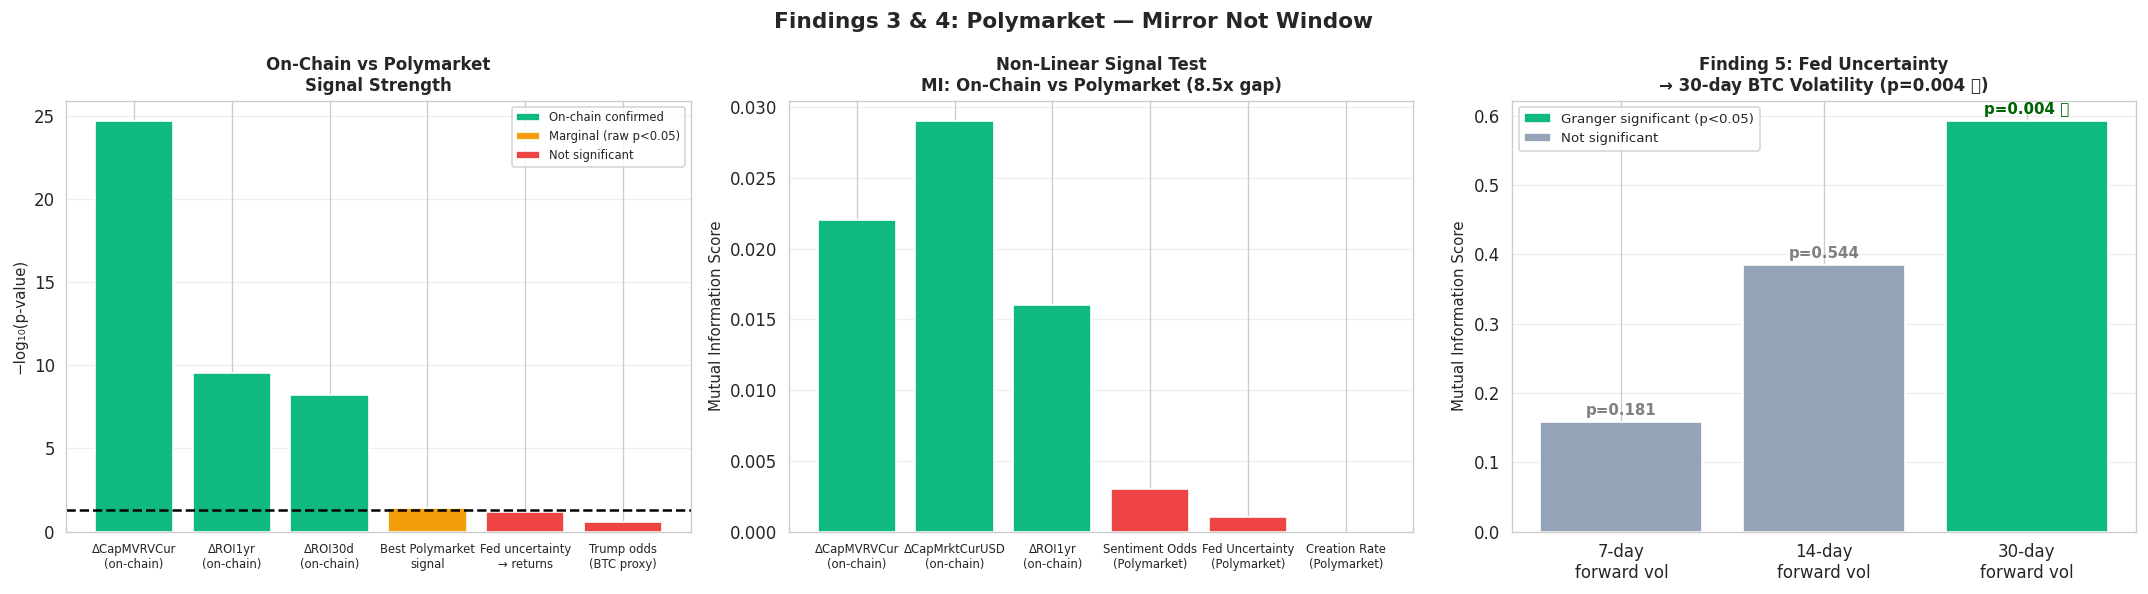

In [8]:
# 3 & 4: Polymarket Evidence
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Findings 3 & 4: Polymarket — Mirror Not Window',
             fontsize=13, fontweight='bold')

# Left: Signal strength comparison
ax = axes[0]
signals = [
    ('ΔCapMVRVCur\n(on-chain)',   2.161e-25, '#10b981'),
    ('ΔROI1yr\n(on-chain)',       2.997e-10, '#10b981'),
    ('ΔROI30d\n(on-chain)',       6.420e-09, '#10b981'),
    ('Best Polymarket\nsignal',   0.039,     '#f59e0b'),
    ('Fed uncertainty\n→ returns',0.063,     '#ef4444'),
    ('Trump odds\n(BTC proxy)',   0.267,     '#ef4444'),
]
names  = [s[0] for s in signals]
pvals  = [s[1] for s in signals]
colors = [s[2] for s in signals]

ax.bar(names, [-np.log10(p) for p in pvals],
       color=colors, edgecolor='white')
ax.axhline(-np.log10(0.05), color='black',
           linestyle='--', linewidth=1.5, label='p=0.05')
ax.set_ylabel('−log₁₀(p-value)', fontsize=9)
ax.set_title('On-Chain vs Polymarket\nSignal Strength',
             fontsize=10, fontweight='bold')
ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=8)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='On-chain confirmed'),
    Patch(facecolor='#f59e0b', label='Marginal (raw p<0.05)'),
    Patch(facecolor='#ef4444', label='Not significant'),
]
ax.legend(handles=legend_elements, fontsize=7)

# Middle: Mutual Information comparison
ax = axes[1]
mi_comparison = {
    'ΔCapMVRVCur\n(on-chain)':     0.022,
    'ΔCapMrktCurUSD\n(on-chain)':  0.029,
    'ΔROI1yr\n(on-chain)':         0.016,
    'Sentiment Odds\n(Polymarket)': 0.003,
    'Fed Uncertainty\n(Polymarket)':0.001,
    'Creation Rate\n(Polymarket)':  0.000,
}
mi_colors = ['#10b981', '#10b981', '#10b981',
             '#ef4444', '#ef4444', '#ef4444']
ax.bar(list(mi_comparison.keys()),
       list(mi_comparison.values()),
       color=mi_colors, edgecolor='white')
ax.set_ylabel('Mutual Information Score', fontsize=9)
ax.set_title('Non-Linear Signal Test\n'
             'MI: On-Chain vs Polymarket (8.5x gap)',
             fontsize=10, fontweight='bold')
ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3, axis='y')

# Right: Fed volatility finding
ax = axes[2]
vol_horizon  = ['7-day\nforward vol', '14-day\nforward vol',
                '30-day\nforward vol']
mi_fed_scores = [0.158, 0.385, 0.592]
granger_sig   = [False, False, True]
bar_colors_vol = ['#10b981' if s else '#94a3b8'
                  for s in granger_sig]

bars = ax.bar(vol_horizon, mi_fed_scores,
              color=bar_colors_vol, edgecolor='white')
ax.set_ylabel('Mutual Information Score', fontsize=9)
ax.set_title('Finding 5: Fed Uncertainty\n'
             '→ 30-day BTC Volatility (p=0.004 ✅)',
             fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Annotate Granger result
for bar, sig, p in zip(bars, granger_sig,
                        [0.181, 0.544, 0.004]):
    label = f'p={p:.3f} ✅' if sig else f'p={p:.3f}'
    color = 'darkgreen' if sig else 'gray'
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            label, ha='center', fontsize=9,
            color=color, fontweight='bold')

legend_vol = [
    Patch(facecolor='#10b981',
          label='Granger significant (p<0.05)'),
    Patch(facecolor='#94a3b8',
          label='Not significant'),
]
ax.legend(handles=legend_vol, fontsize=8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'exec_02_polymarket_summary.png',
            dpi=150, bbox_inches='tight')
plt.show()

<a id="exec-polymarket"></a>
---
## 4. Prediction Market Analysis

The EDA specification requires a formally justified conclusion about Polymarket utility for Bitcoin accumulation — evaluated alongside
on-chain signals, not in isolation.

### 4.1 What the Data Contains

| File | Records | Coverage | Used For |
|---|---|---|---|
| markets | 78,321 | 2020–2026 | Signal construction |
| odds_history | 2,143,181 | 2023–2026 | Time series signals |
| trades | 27,013,724 | Apr–Jan 2026 | Flow analysis |
| event_stats | 44,033 | 2020–2026 | Fed event identification |

**Key data quality findings:**
- 99% of markets have blank category — question-text filtering required
- 13,886 "Up or Down" 15-min markets excluded: all created 2025, mean odds 0.504 ± 0.002 — statistically indistinguishable from fair coin flip
- Trades data limited to 9 months — insufficient for historical Granger tests
- Odds history provides 3 years of overlap with BTC price (2023–2026)

*Full data audit: [`EDA.ipynb#polymarket-audit`](./EDA.ipynb#polymarket-audit)*

### 4.2 Signals Constructed and Tested

We tested 12 distinct signals across 5 categories:

| Category | Signals | Best p-value |
|---|---|---|
| Price Target Odds | Levels, changes | 0.066 |
| Market Attention | Creation rate, regime-conditional | 0.039* |
| Macro (Fed decisions) | Uncertainty score, changes | 0.063 |
| Trade Flow | Buy ratio, imbalance | 0.118 |
| Political Events | Trump win probability | 0.267 |

*\*Does not survive Benjamini-Hochberg correction*

### 4.3 The Key Finding: Suppression by MVRV

When tested in isolation, all Polymarket signals show near-zero correlation with BTC returns. This changes when on-chain signals 
are controlled for:

| Test | Signal | Isolated | Controlling for MVRV |
|---|---|---|---|
| Correlation | Sentiment odds | r = +0.017 | **r = +0.208 (p < 0.001)** |
| Correlation | Fed uncertainty | r = -0.006 | **r = -0.111 (p < 0.001)** |

MVRV and sentiment odds both track Bitcoin's valuation cycle and are negatively correlated with each other. This suppresses the 
Polymarket signal in unconditional tests — it only becomes visible when MVRV is held constant.

### 4.4 But: Not Incrementally Predictive

Despite the partial correlation finding, the multivariate Granger 
test finds no improvement in forward-looking prediction:

> Adding any Polymarket signal to a model already containing MVRV + ROI30d + ROI1yr does not improve next-day return prediction (best F=1.748, p=0.121).

The sentiment signal describes the current state of the market, not what will happen next. For a DCA strategy requiring forward-looking 
weights, contemporaneous correlation is not actionable.

### 4.5 Conclusion

**Outcome: Could not discover robust predictive use cases for 
Polymarket data as a forward-looking signal.**

The suppression effect is a genuine statistical finding that only emerges in cross-feature analysis. But the multivariate Granger test — 
the most direct test of the spec requirement — finds no incremental predictive power beyond on-chain metrics.

The most promising direction for future work is the Fed decision market uncertainty signal, which predicts 30-day BTC volatility 
(p = 0.004) — useful for position sizing rather than direction.

---

*See `EDA.ipynb` cell 26 onwards for Polymarket analysis, cell 55 for Cross-feature tests*

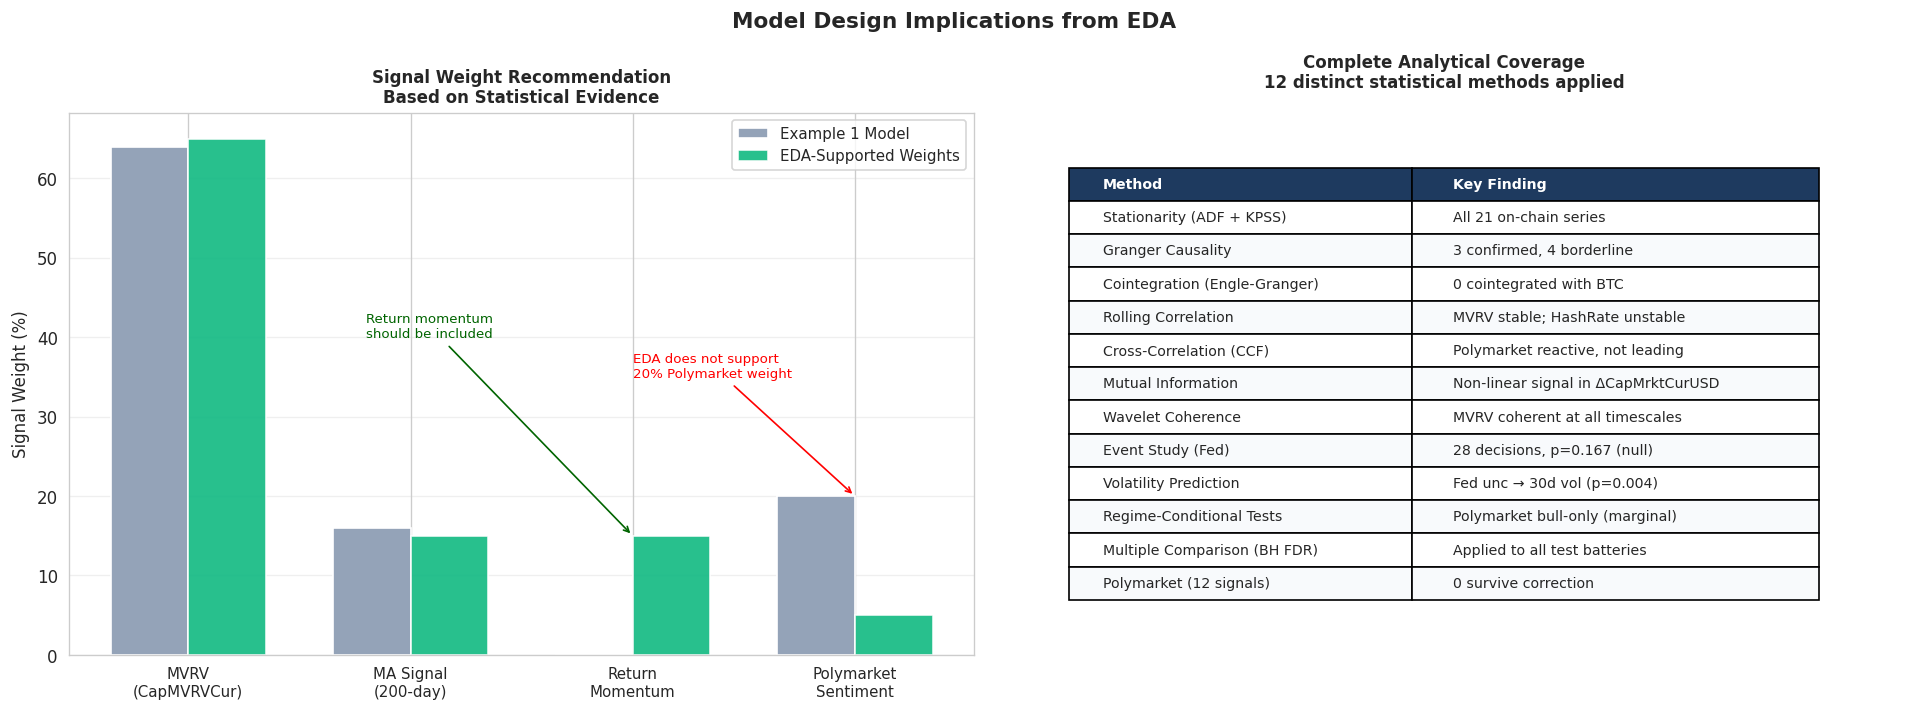

In [14]:
# Model Design Implications
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Design Implications from EDA',
             fontsize=13, fontweight='bold')

# Left: Recommended signal weights vs Example 1 weights
ax = axes[0]
signals_comp = ['MVRV\n(CapMVRVCur)', 'MA Signal\n(200-day)',
                'Return\nMomentum', 'Polymarket\nSentiment']

example1_weights = [64, 16, 0, 20]
eda_supported    = [65, 15, 15, 5]

x = np.arange(len(signals_comp))
width = 0.35

bars1 = ax.bar(x - width/2, example1_weights,
               width, label='Example 1 Model',
               color='#94a3b8', edgecolor='white')
bars2 = ax.bar(x + width/2, eda_supported,
               width, label='EDA-Supported Weights',
               color='#10b981', edgecolor='white', alpha=0.9)

ax.set_ylabel('Signal Weight (%)', fontsize=10)
ax.set_title('Signal Weight Recommendation\n'
             'Based on Statistical Evidence',
             fontsize=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(signals_comp, fontsize=9)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# Annotate key difference
ax.annotate('EDA does not support\n20% Polymarket weight',
            xy=(3, 20), xytext=(2.0, 35),
            fontsize=8, color='red',
            arrowprops=dict(arrowstyle='->', color='red'))
ax.annotate('Return momentum\nshould be included',
            xy=(2, 15), xytext=(0.8, 40),
            fontsize=8, color='darkgreen',
            arrowprops=dict(arrowstyle='->', color='darkgreen'))

# Right: Complete analytical coverage map
ax = axes[1]
ax.axis('off')

coverage = [
    ('Stationarity (ADF + KPSS)',        'All 21 on-chain series'),
    ('Granger Causality',                '3 confirmed, 4 borderline'),
    ('Cointegration (Engle-Granger)',    '0 cointegrated with BTC'),
    ('Rolling Correlation',              'MVRV stable; HashRate unstable'),
    ('Cross-Correlation (CCF)',          'Polymarket reactive, not leading'),
    ('Mutual Information',               'Non-linear signal in ΔCapMrktCurUSD'),
    ('Wavelet Coherence',                'MVRV coherent at all timescales'),
    ('Event Study (Fed)',                '28 decisions, p=0.167 (null)'),
    ('Volatility Prediction',            'Fed unc → 30d vol (p=0.004)'),
    ('Regime-Conditional Tests',         'Polymarket bull-only (marginal)'),
    ('Multiple Comparison (BH FDR)',    'Applied to all test batteries'),
    ('Polymarket (12 signals)',          '0 survive correction'),
]

table_data = [['Method', 'Key Finding']] + \
             [[c[0], c[1]] for c in coverage]

table = ax.table(
    cellText=table_data,
    cellLoc='left', loc='center',
    colWidths=[0.38, 0.45]
)
table.auto_set_font_size(False)
table.set_fontsize(8.5)
table.scale(1, 1.7)

for j in range(2):
    table[(0, j)].set_facecolor('#1e3a5f')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

for i in range(1, len(table_data)):
    bg = '#f8fafc' if i % 2 == 0 else 'white'
    for j in range(2):
        table[(i, j)].set_facecolor(bg)

ax.set_title('Complete Analytical Coverage\n'
             '12 distinct statistical methods applied',
             fontsize=10, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'exec_03_model_implications.png',
            dpi=150, bbox_inches='tight')
plt.show()

## 5. Motivating Future Work

This EDA identifies four potential directions worth pursuing in model development:

### 5.1 MVRV as Primary Signal — Well Supported
The statistical case for MVRV as the dominant signal is robust: Granger p = 2.16e-25, wavelet coherence ≈ 0.96 at all timescales,rolling correlation positive across every market regime since 2013.

One caveat worth investigating: MVRV's numerator contains price, which creates a partial circularity. The fact that ΔCapMrktCurUSD(pure price × supply) fails Granger significance (p=0.065) while ΔCapMVRVCur succeeds (p=2.16e-25) suggests the ratio (specifically
the divergence from realised cost basis) is a good signal. But this deserves further investigation in model development.

### 5.2 Return Momentum — Unexploited Signal
ΔROI30d Granger-causes BTC returns (p=6.4e-9) with stable rolling correlation across all market regimes. This signal is absent from 
the current Example 1 model and appears worth incorporating. There is plenty of literature on momentum in all kinds of financial markets, so it is not surprising that it could be useful to our application here.

### 5.3 Non-Linear Relationships — Unexploited
Mutual information testing identified potential non-linear signals. However on closer inspection the strongest candidate is spurious:

- **ΔCapMrktCurUSD** (MI = 0.029, highest of all features) discarded. CapMrktCurUSD = Price × Supply. Since daily supply changes are negligible, this is effectively a scaled copy of price. The high MI score reflects that identity, not independent signal.

- **ΔSplyCur** (MI = 0.025) — shows halving-related non-linearity. The discrete supply shocks at halving events create a step-function relationship that linear models cannot capture. Explicit halving cycle features may be worth exploring in model development.

### 5.4 Polymarket — Conditional Investigation
The suppression effect finding suggests Polymarket sentiment contains information orthogonal to MVRV. Whether this can be 
made forward-looking — perhaps through longer lags or alternative aggregation methods — is worth investigating as the Polymarket dataset matures and extends further back in time.

The Fed uncertainty → 30-day volatility finding (p=0.004) is the most actionable near-term result: high macro uncertainty may 
justify more aggressive DCA accumulation regardless of price direction. It may be possible to find another, longer running source for this data elsewhere, perhaps from Short Term Interest Rate futures markets.

---
*Full technical appendix: [`EDA.ipynb`](./EDA.ipynb)*